# Random Forest Tuning (Descriptors + Fingerprints)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import Descriptors, rdMolDescriptors, AllChem, MACCSkeys
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.ML.Descriptors import MoleculeDescriptors as md

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix
)

import xgboost as xgb
from xgboost import XGBClassifier
import shap
import optuna

## Logging results

In [29]:
import pandas as pd

# Глобальный список для хранения всех результатов
all_results = []


def log_result(method_name, model_type, n_features, metrics, params=None, stage=None):
    """
    Сохраняет результаты в глобальную таблицу all_results.

    method_name — SHAP / MI / KBest / Lasso
    model_type — RF / OptunaRF / ExtraTrees / GBoost
    n_features — количество используемых фичей
    metrics — словарь метрик {"Accuracy":..., "F1":..., ...}
    params — словарь параметров модели
    stage — этап: baseline / final / optuna / simple_tuning
    """

    record = {
        "Method": method_name,
        "Model": model_type,
        "Stage": stage,
        "Top_Features": n_features,

        # Метрики
        "Accuracy": metrics.get("Accuracy"),
        "Precision": metrics.get("Precision"),
        "Recall": metrics.get("Recall"),
        "F1": metrics.get("F1"),
        "ROC_AUC": metrics.get("AUC"),
    }

    # Добавляем параметры модели, если есть
    if params is not None:
        for key, value in params.items():
            record[f"Param_{key}"] = value

    all_results.append(record)


def save_results_table(filename="all_results.xlsx"):
    """
    Преобразует global all_results → DataFrame и сохраняет таблицу.
    """
    df = pd.DataFrame(all_results)
    df.to_excel(filename, index=False)
    print(f"Saved full results table to {filename}")
    return df


## Molecule, Descriptor + Fingerprints and Outlier Functions

In [30]:
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem import rdMolDescriptors, MACCSkeys, Descriptors
from rdkit.Chem.rdFingerprintGenerator import (
    GetMorganGenerator,
    GetAtomPairGenerator,
    GetTopologicalTorsionGenerator,
)
from rdkit import DataStructs


def molecule_from_smiles(smiles):
    lg = RDLogger.logger()
    # Temporarily silence RDKit logs
    lg.setLevel(RDLogger.CRITICAL)
    try:
        # Extract molecule
        molecule = Chem.MolFromSmiles(smiles, sanitize=True)
        if molecule is None:
            return None, "failed"

        # Remove salts
        clean_molecule = rdMolStandardize.LargestFragmentChooser()
        molecule = clean_molecule.choose(molecule)

        # Sanitize molecule again to reflect changes
        Chem.SanitizeMol(molecule)
        return molecule, "succeed"
    except Exception as e:
        return None, f"error: {e}"
    finally:
        # Re-enable logging afterward
        lg.setLevel(RDLogger.INFO)


def calculate_descriptors(molecule):
    # Get all descriptors (1D/2D)
    descriptor_names = []
    for descriptor, _ in Descriptors._descList:
        descriptor_names.append(descriptor)

    # Use descriptors to calculate values
    calculator = md.MolecularDescriptorCalculator(descriptor_names)
    descriptor_values = calculator.CalcDescriptors(molecule)

    # Create dictionary
    descriptors = dict(zip(descriptor_names, descriptor_values))
    return descriptors


def compute_iqr_limits(df, factor=1.5):
    # Calculate IQR limits
    limits = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1

        # If IQR is 0 - column is too flat - skip
        if iqr == 0 or np.isnan(iqr):
            continue

        lower = q1 - factor * iqr
        upper = q3 + factor * iqr
        limits[col] = (lower, upper)
    return limits


def apply_iqr_limits(df, limits):
    # Apply the limits
    df_clipped = df.copy()
    for col, (lower, upper) in limits.items():
        df_clipped[col] = df_clipped[col].clip(lower, upper)
    return df_clipped


def bitvect_to_array(fp, n_bits):
    """Перевод ExplicitBitVect → numpy-вектор 0/1 фиксированной длины."""
    arr = np.zeros((n_bits,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


def fp_to_array_safe(fp, n_bits, fp_name):
    """Безопасный перевод fingerprint → numpy-вектор."""
    if fp is None:
        print(f"[WARN] {fp_name} is None → zero vector")
        return np.zeros((n_bits,), dtype=np.int8)

    arr = np.zeros((n_bits,), dtype=np.int8)
    try:
        DataStructs.ConvertToNumpyArray(fp, arr)
    except Exception as e:
        print(f"[ERROR] Cannot convert {fp_name}: {e}")
        return np.zeros((n_bits,), dtype=np.int8)

    return arr


def calculate_fingerprints_vector(mol):
    """
    Возвращает единый вектор фингерпринтов:
    Morgan + RDK + MACCS + AtomPair + Torsion.
    Всегда фиксированной длины, только 0/1.
    """
    # Если молекула невалидная — нулевой вектор нужной длины
    if mol is None:
        total_bits = 2048 + 2048 + 167 + 2048 + 2048
        return np.zeros((total_bits,), dtype=np.int8)

    # --- MORGAN ---
    morgan_bits = 2048
    try:
        morgan_gen = GetMorganGenerator(radius=2, fpSize=morgan_bits)
        fp_morgan = morgan_gen.GetFingerprint(mol)
    except Exception as e:
        print("[ERROR] Morgan FP failed:", e)
        fp_morgan = None
    arr_morgan = fp_to_array_safe(fp_morgan, morgan_bits, "Morgan")

    # --- RDKit topological ---
    rdk_bits = 2048
    try:
        fp_rdk = Chem.RDKFingerprint(mol, fpSize=rdk_bits)
    except Exception as e:
        print("[ERROR] RDK FP failed:", e)
        fp_rdk = None
    arr_rdk = fp_to_array_safe(fp_rdk, rdk_bits, "RDK")

    # --- MACCS KEYS ---
    maccs_bits = 167
    try:
        fp_maccs = MACCSkeys.GenMACCSKeys(mol)
    except Exception as e:
        print("[ERROR] MACCS FP failed:", e)
        fp_maccs = None
    arr_maccs = fp_to_array_safe(fp_maccs, maccs_bits, "MACCS")
    # MACCS → бинаризация (иногда бывают значения >1)
    arr_maccs = (arr_maccs > 0).astype(np.int8)

    # --- ATOM PAIR ---
    ap_bits = 2048
    try:
        ap_gen = GetAtomPairGenerator(fpSize=ap_bits)
        fp_ap = ap_gen.GetFingerprint(mol)
    except Exception as e:
        print("[ERROR] AtomPair FP failed:", e)
        fp_ap = None
    arr_ap = fp_to_array_safe(fp_ap, ap_bits, "AtomPair")

    # --- TORSION ---
    tt_bits = 2048
    try:
        tt_gen = GetTopologicalTorsionGenerator(fpSize=tt_bits)
        fp_tt = tt_gen.GetFingerprint(mol)
    except Exception as e:
        print("[ERROR] Torsion FP failed:", e)
        fp_tt = None
    arr_tt = fp_to_array_safe(fp_tt, tt_bits, "Torsion")

    # Финальное объединение в один длинный вектор
    fp_vector = np.concatenate([arr_morgan, arr_rdk, arr_maccs, arr_ap, arr_tt])

    # Контроль длины
    expected_len = 2048 + 2048 + 167 + 2048 + 2048
    if fp_vector.shape[0] != expected_len:
        print("[FATAL] FP vector wrong length:", fp_vector.shape, "expected:", expected_len)

    return fp_vector


def build_feature_matrices(smiles_list):
    """
    Основная функция:
    - парсит SMILES → молекулы
    - считает дескрипторы → DataFrame X_desc
    - считает фингерпринты → numpy-матрица X_fp
    - возвращает X_desc, X_fp, и при желании X_total
    """
    mols = []
    desc_rows = []
    fp_rows = []

    for s in smiles_list:
        mol, status = molecule_from_smiles(s)
        mols.append(mol)

        # Дескрипторы
        desc = calculate_descriptors(mol) if mol is not None else {}
        desc_rows.append(desc)

        # Вектор фингерпринтов
        fp_vec = calculate_fingerprints_vector(mol)
        fp_rows.append(fp_vec)

    # Дескрипторы → DataFrame (можно потом заполнить NaN/0)
    X_desc = pd.DataFrame(desc_rows)

    # Фингерпринты → матрица (n_samples, d_fp)
    X_fp = np.vstack(fp_rows)

    return X_desc, X_fp

## Dataset Processing

In [35]:
# Configuration
ORIG_DATASET = "in_chemico_dataset.xlsx"
SKIP_ROWS = 1
SMILES_COL = "SMILES code"
TARGET_COL = "Phototoxicity"
FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"

# Outputs
TRAIN_X_CSV = "in_chemico_x_train.csv"
TEST_X_CSV = "in_chemico_x_test.csv"
TRAIN_Y_CSV = "in_chemico_y_train.csv"
TEST_Y_CSV = "in_chemico_y_test.csv"

# Near constant threshold - tolerance
SIMILARITY_THRESHOLD = 0.7
# Correlation threshold
CORRELATION_THRESHOLD = 0.65

# Load dataset and skip first row (Header)
dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)

descriptor_rows = []
state_molecules = []
molecules = []
fp_rows = []  # сюда складываем векторы фингерпринтов

for smiles in dataset[SMILES_COL].astype(str):
    molecule, state = molecule_from_smiles(smiles)
    state_molecules.append(state)
    molecules.append(molecule)

    if molecule is None:
        descriptor_rows.append({})
        # для невалидной молекулы — нулевой вектор нужной длины
        fp_rows.append(calculate_fingerprints_vector(None))
        continue

    # 1D/2D RDKit descriptors
    desc_feats = calculate_descriptors(molecule)

    # НЕПРАВИЛЬНО: разворачивали фингерпринты в словарь с тысячами колонок
    # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
    # fp_feats = calculate_fingerprints_vector(molecule)
    # # Merge both dicts into one feature row
    # all_feats = {**desc_feats, **fp_feats}
    # descriptor_rows.append(all_feats)

    # оставляем дескрипторы диктом, а фингерпринты — как один numpy-вектор
    descriptor_rows.append(desc_feats)
    fp_vec = calculate_fingerprints_vector(molecule)
    fp_rows.append(fp_vec)


# Convert list of dictionaries into dataframe
descriptor_data_all = pd.DataFrame(descriptor_rows)

# матрица фингерпринтов (n_samples, d_fp)
X_fp_all = np.vstack(fp_rows)

# Keep everything + status
output = pd.concat(
    [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
    axis=1
)
output["MoleculeStatus"] = state_molecules

# Output whole dataset with descriptors and state
with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
    output.to_excel(writer, index=False, sheet_name="Descriptors")

# print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
print(output.head().to_string(index=False))

# Drop failed molecules - boolean array
molecules_right = []
for molecule in molecules:
    if molecule is not None:
        molecules_right.append(True)
    else:
        molecules_right.append(False)
if not any(molecules_right):
    raise ValueError("No valid molecules after SMILES parsing.")

dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)

# отфильтровываем те же строки в матрице фингерпринтов
X_fp_ok = X_fp_all[molecules_right, :]
print("X_fp_ok shape:", X_fp_ok.shape)
# Target
y_full = dataset_ok[TARGET_COL].astype(int)

# Take only numeric descriptor columns
X_desc_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
# Replace infinities with NaN
for column in X_desc_full.columns:
    X_desc_full[column] = X_desc_full[column].replace([np.inf, -np.inf], np.nan)

print("X_desc_full shape:", X_desc_full.shape)

# Drop columns that are entirely NaN
all_nan_cols = X_desc_full.columns[X_desc_full.isna().all()].tolist()
if all_nan_cols:
    print(f"Dropping {len(all_nan_cols)} NaN columns.")
    X_desc_full = X_desc_full.drop(columns=all_nan_cols)

# объединяем дескрипторы и фингерпринты в одну матрицу признаков
# Важно: сначала приводим дескрипторы к numpy
X_desc_np = X_desc_full.to_numpy(dtype=float)
X_full = np.concatenate([X_desc_np, X_fp_ok], axis=1)

# Для удобства дальше работать как с DataFrame:
desc_cols = list(X_desc_full.columns)
fp_dim = X_fp_ok.shape[1]
fp_cols = [f"FP_{i}" for i in range(fp_dim)]
X_full = pd.DataFrame(X_full, columns=desc_cols + fp_cols)
print("X_full before filtering:", X_full.shape)

# Split dataset - train and test
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

# Calculate medians for each column in train only
train_medians = X_train.median(numeric_only=True)

# Fill missing values in both train and test using those medians
X_train = X_train.fillna(train_medians)
X_test = X_test.fillna(train_medians)

# Compute constants on train only
constant_cols = []
for col in X_train.columns:
    top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
    if top_freq >= SIMILARITY_THRESHOLD:
        constant_cols.append(col)

# Drop from train and apply same drop to test
if constant_cols:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)
    print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")

# Compute absolute correlation matrix on training data
corr_matrix = X_train.corr().abs()
# Keep only upper triangle of the matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Find columns to drop - correlation
high_corr_cols = []
for col in upper.columns:
    if any(upper[col] > CORRELATION_THRESHOLD):
        high_corr_cols.append(col)

# Drop from both train and test
if high_corr_cols:
    X_train = X_train.drop(columns=high_corr_cols)
    X_test = X_test.drop(columns=high_corr_cols)
    print(f"Dropped {len(high_corr_cols)} highly correlated columns.")


print("constant_cols:", len(constant_cols))
print("high_corr_cols:", len(high_corr_cols))

# Compute IQR limits on training data
iqr_limits = compute_iqr_limits(X_train, factor=1.5)

# Apply limits to both train and test sets
X_train = apply_iqr_limits(X_train, iqr_limits)
X_test = apply_iqr_limits(X_test, iqr_limits)

# Scaling not necessary for all models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

X_train.to_csv(TRAIN_X_CSV, index=False)
X_test.to_csv(TEST_X_CSV, index=False)
y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])

print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# print("First rows of train x:")
# print(X_train.head().to_string(index=False))
print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
# print("First rows of train y:")
# print(y_train.head().to_string(index=False))
# X_train.describe()

print("\nTrain set class counts:")
print(y_train.value_counts())
print("\nTrain set class ratio:")
print(y_train.value_counts(normalize=True))

print("\nTest set class counts:")
print(y_test.value_counts())
print("\nTest set class ratio:")
print(y_test.value_counts(normalize=True))

Full - Rows: 162/Columns: 230
                          Name                                                                                              IUPAC name CAS registry number    Structure  Phototoxicity                                                      SMILES code                            Sources               Note    Unnamed: 8 Unnamed: 9  Unnamed: 10 Unnamed: 11  MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex      qed       SPS   MolWt  HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  NumRadicalElectrons  MaxPartialCharge  MinPartialCharge  MaxAbsPartialCharge  MinAbsPartialCharge  FpDensityMorgan1  FpDensityMorgan2  FpDensityMorgan3  BCUT2D_MWHI  BCUT2D_MWLOW  BCUT2D_CHGHI  BCUT2D_CHGLO  BCUT2D_LOGPHI  BCUT2D_LOGPLOW  BCUT2D_MRHI  BCUT2D_MRLOW   AvgIpc  BalabanJ    BertzCT      Chi0     Chi0n     Chi0v      Chi1    Chi1n    Chi1v    Chi2n    Chi2v    Chi3n    Chi3v    Chi4n    Chi4v  HallKierAlpha           Ipc    Kappa1   Kappa2   Kappa3  Labute

In [ ]:
#

In [32]:
# # Configuration
# ORIG_DATASET = "in_chemico_dataset.xlsx"
# SKIP_ROWS = 1
# SMILES_COL = "SMILES code"
# TARGET_COL = "Phototoxicity"
# FULL_OUTPUT_DATASET = "in_chemico_dataset_processed.xlsx"
#
# # Outputs
# TRAIN_X_CSV = "in_chemico_x_train.csv"
# TEST_X_CSV = "in_chemico_x_test.csv"
# TRAIN_Y_CSV = "in_chemico_y_train.csv"
# TEST_Y_CSV = "in_chemico_y_test.csv"
#
# # Near constant threshold - tolerance
# SIMILARITY_THRESHOLD = 0.7
# # Correlation threshold
# CORRELATION_THRESHOLD = 0.65
#
# # Load dataset and skip first row (Header)
# dataset = pd.read_excel(ORIG_DATASET, engine="openpyxl", skiprows=SKIP_ROWS)
#
# descriptor_rows = []
# state_molecules = []
# molecules = []
#
# for smiles in dataset[SMILES_COL].astype(str):
#     molecule, state = molecule_from_smiles(smiles)
#     state_molecules.append(state)
#     molecules.append(molecule)
#
#     if molecule is None:
#         descriptor_rows.append({})
#         continue
#
#     # 1D/2D RDKit descriptors
#     desc_feats = calculate_descriptors(molecule)
#
#     # Calculate Morgan, RDKit, MACCS, AtomPair and Topological Torsion fingerprint
#     fp_feats = calculate_fingerprints(molecule)
#
#     # Merge both dicts into one feature row
#     all_feats = {**desc_feats, **fp_feats}
#     descriptor_rows.append(all_feats)
#
# # Convert list of dictionaries into dataframe
# descriptor_data_all = pd.DataFrame(descriptor_rows)
#
# # Keep everything + status
# output = pd.concat(
#     [dataset.reset_index(drop=True), descriptor_data_all.reset_index(drop=True)],
#     axis=1
# )
# output["MoleculeStatus"] = state_molecules
#
# # Output whole dataset with descriptors and state
# with pd.ExcelWriter(FULL_OUTPUT_DATASET, engine="openpyxl") as writer:
#     output.to_excel(writer, index=False, sheet_name="Descriptors")
#
# print(f"Full - Rows: {len(output)}/Columns: {output.shape[1]}")
# print(output.head().to_string(index=False))
#
# # Drop failed molecules - boolean array
# molecules_right = []
# for molecule in molecules:
#     if molecule is not None:
#         molecules_right.append(True)
#     else:
#         molecules_right.append(False)
# if not any(molecules_right):
#     raise ValueError("No valid molecules after SMILES parsing.")
#
# dataset_ok = dataset.loc[molecules_right].reset_index(drop=True)
# descriptor_ok = descriptor_data_all.loc[molecules_right].reset_index(drop=True)
#
# # Target
# y_full = dataset_ok[TARGET_COL].astype(int)
#
# # Take only numeric descriptor columns
# X_full = descriptor_ok.select_dtypes(include=[np.number]).copy()
# for column in X_full.columns:
#     X_full[column] = X_full[column].replace([np.inf, -np.inf], np.nan)
#
# # Drop columns that are entirely NaN
# all_nan_cols = X_full.columns[X_full.isna().all()].tolist()
# if all_nan_cols:
#     print(f"Dropping {len(all_nan_cols)} NaN columns.")
#     X_full = X_full.drop(columns=all_nan_cols)
#
# # Split dataset - train and test
# X_train, X_test, y_train, y_test = train_test_split(
#     X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
# )
#
# # Calculate medians for each column in train only
# train_medians = X_train.median(numeric_only=True)
#
# # Fill missing values in both train and test using those medians
# X_train = X_train.fillna(train_medians)
# X_test = X_test.fillna(train_medians)
#
# # Compute constants on train only
# constant_cols = []
# for col in X_train.columns:
#     top_freq = X_train[col].value_counts(normalize=True, dropna=False).max()
#     if top_freq >= SIMILARITY_THRESHOLD:
#         constant_cols.append(col)
#
# # Drop from train and apply same drop to test
# if constant_cols:
#     X_train = X_train.drop(columns=constant_cols)
#     X_test = X_test.drop(columns=constant_cols)
#     print(f"Dropped {len(constant_cols)} constant/almost-constant columns.")
#
# # Compute absolute correlation matrix on training data
# corr_matrix = X_train.corr().abs()
# # Keep only upper triangle of the matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# # Find columns to drop - correlation
# high_corr_cols = []
# for col in upper.columns:
#     if any(upper[col] > CORRELATION_THRESHOLD):
#         high_corr_cols.append(col)
#
# # Drop from both train and test
# if high_corr_cols:
#     X_train = X_train.drop(columns=high_corr_cols)
#     X_test = X_test.drop(columns=high_corr_cols)
#     print(f"Dropped {len(high_corr_cols)} highly correlated columns.")
#
# # Compute IQR limits on training data
# iqr_limits = compute_iqr_limits(X_train, factor=1.5)
#
# # Apply limits to both train and test sets
# X_train = apply_iqr_limits(X_train, iqr_limits)
# X_test = apply_iqr_limits(X_test, iqr_limits)
#
# # Scaling not necessary for all models
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
#
# X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
# X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
#
# X_train.to_csv(TRAIN_X_CSV, index=False)
# X_test.to_csv(TEST_X_CSV, index=False)
# y_train.to_csv(TRAIN_Y_CSV, index=False, header=[TARGET_COL])
# y_test.to_csv(TEST_Y_CSV, index=False, header=[TARGET_COL])
#
# print(f"Train - Rows: {len(X_train)}/Columns: {X_train.shape[1]}")
# print("First rows of train x:")
# print(X_train.head().to_string(index=False))
# print(f"Test - Rows: {len(X_test)}/Columns: {X_test.shape[1]}")
# print("First rows of train y:")
# print(y_train.head().to_string(index=False))
# X_train.describe()
#
# print("\nTrain set class counts:")
# print(y_train.value_counts())
# print("\nTrain set class ratio:")
# print(y_train.value_counts(normalize=True))
#
# print("\nTest set class counts:")
# print(y_test.value_counts())
# print("\nTest set class ratio:")
# print(y_test.value_counts(normalize=True))

In [33]:
X_train.shape[1]

974

In [34]:
X_train.shape[0]

129

## Base Model Train

In [36]:
from sklearn.ensemble import RandomForestClassifier

# Base Random Forest model
base_model = RandomForestClassifier(
    n_estimators=X_train.shape[1],
    random_state=42,
    class_weight="balanced"
)

# Train
base_model.fit(X_train, y_train)

# Predict
y_pred = base_model.predict(X_test)
y_prob = base_model.predict_proba(X_test)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nRandom Forest performance:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


Random Forest performance:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.8037

Classification report:
              precision    recall  f1-score   support

           0      0.647     0.733     0.688        15
           1      0.750     0.667     0.706        18

    accuracy                          0.697        33
   macro avg      0.699     0.700     0.697        33
weighted avg      0.703     0.697     0.698        33



## Feature Selection

In [37]:
import shap
from sklearn.feature_selection import mutual_info_classif


# === 2. SHAP Importance ===
# SHAP ti ukazuje, ako každý príznak (MACCS bit) prispieva ku konečnej predikcii.
# Je to najinterpretovateľnejšia metóda (globálne aj lokálne).

f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

shap_values = shap_result.values
shap_importance = np.abs(shap_values).mean(axis=0)

shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# === 3. Mutual Information (MI) ===
# MI meria, koľko informácie nesie každý príznak o cieľovej triede.
# Je veľmi stabilná metóda pre malé datasety a zmiešané typy príznakov.
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True, random_state=42)

mi_features = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# === 4. ANOVA F-score (SelectKBest) ===
# ANOVA porovnáva priemerné hodnoty príznakov medzi triedami.
# Je to čistý štatistický pohľad – nezávislý od modelu.
kbest = SelectKBest(score_func=f_classif, k='all')
kbest.fit(X_train, y_train)
kbest_scores = pd.Series(kbest.scores_, index=X_train.columns).fillna(0)
kbest_features = kbest_scores.sort_values(ascending=False)

# === 5. Lasso Logistic Regression (L1 koeficienty) ===
# Lasso dáva lineárny pohľad na dôležitosť príznakov – veľké koeficienty = dôležitý príznak.
# Veľkou výhodou je, že zriedi nepotrebné príznaky (robí sparse model).
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 6. vizualizácia ===
shap.summary_plot(shap_values, X_train)

# Print best features for each method
print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())
print("\nTop 10 K-Best features:")
print(kbest_features.head(10).to_string())
print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())

PermutationExplainer explainer: 130it [40:28, 18.83s/it]                         


KeyboardInterrupt: 

PermutationExplainer explainer: 130it [35:55, 16.84s/it]                         
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics


SelectFromModel (RF) selected 487 features.
First 10 selected features: ['MaxAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'MinPartialCharge', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_MRLOW']


C:\Users\sirad\AppData\Local\Temp\ipykernel_900\3647389668.py:59: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)


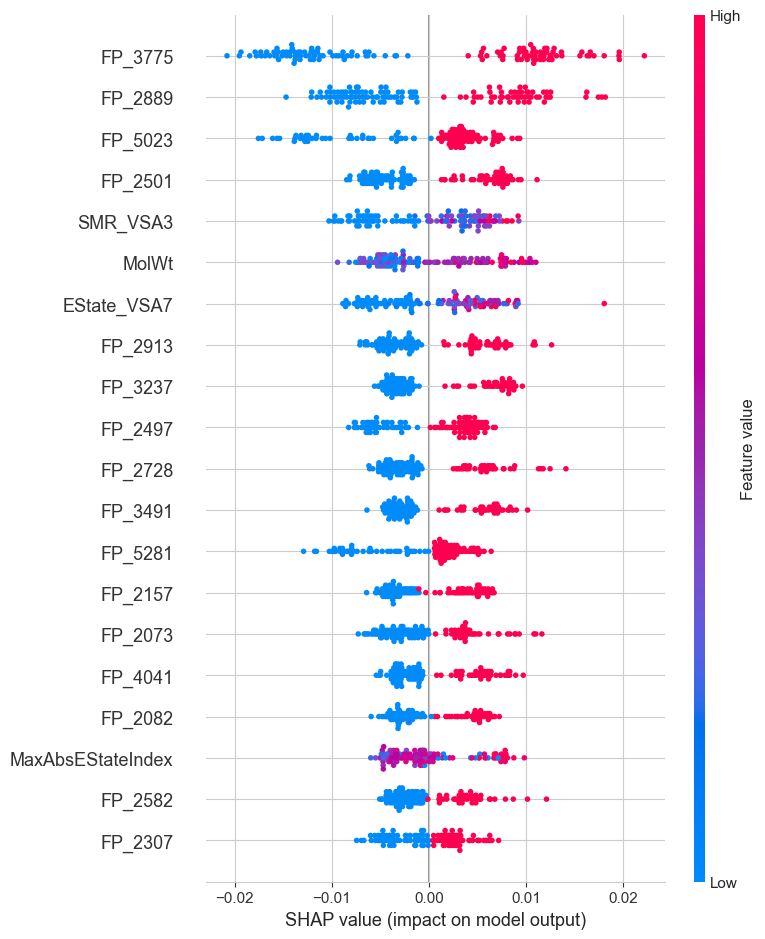


Top 10 SHAP features:
FP_3775        0.011911
FP_2889        0.007847
FP_5023        0.005632
FP_2501        0.005366
SMR_VSA3       0.004921
MolWt          0.004852
EState_VSA7    0.004845
FP_2913        0.004559
FP_3237        0.004437
FP_2497        0.004369

Top 10 MI features:
BCUT2D_MWHI          0.679965
qed                  0.679965
Kappa3               0.679965
BCUT2D_MRLOW         0.662528
MinPartialCharge     0.654416
MolWt                0.646964
MaxAbsEStateIndex    0.632037
BCUT2D_MWLOW         0.630514
SPS                  0.606301
Ipc                  0.597139

Top 10 Permutation features:
MolWt               0.001550
FP_2889             0.000775
Ipc                 0.000775
MinEStateIndex      0.000000
qed                 0.000000
SPS                 0.000000
MinPartialCharge    0.000000
FpDensityMorgan1    0.000000
BCUT2D_MWHI         0.000000
BCUT2D_MWLOW        0.000000

Top 10 RF feature_importances_ features:
FP_3775              0.021840
SMR_VSA3             0.0

In [38]:
import shap
from sklearn.feature_selection import mutual_info_classif, SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# === 1. SHAP Importance ===
f = lambda X: base_model.predict_proba(X)[:, 1]

explainer = shap.Explainer(f, X_train)
shap_result = explainer(X_train, max_evals=2 * X_train.shape[1] + 50)

shap_values = shap_result.values
shap_importance = np.abs(shap_values).mean(axis=0)
shap_features = pd.Series(shap_importance, index=X_train.columns).sort_values(ascending=False)

# === 2. Mutual Information (MI) ===
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=True, random_state=42)
mi_features = pd.Series(mi_scores, index=X_train.columns).sort_values(ascending=False)

# === 3. Permutation Importance (модельно-зависимый отбор) ===
perm = permutation_importance(base_model, X_train, y_train, n_repeats=10, random_state=42)
perm_features = pd.Series(perm.importances_mean, index=X_train.columns).sort_values(ascending=False)

# === 4. Lasso Logistic Regression (L1 коэф.) ===
lasso = LogisticRegression(
    penalty='l1',
    C=1.0,
    solver='liblinear',
    max_iter=5000
)
lasso.fit(X_train, y_train)

lasso_importance = pd.Series(np.abs(lasso.coef_).ravel(), index=X_train.columns)
lasso_features = lasso_importance.sort_values(ascending=False)

# === 5. Визуализация и вывод ===
shap.summary_plot(shap_values, X_train)

print("\nTop 10 SHAP features:")
print(shap_features.head(10).to_string())

print("\nTop 10 MI features:")
print(mi_features.head(10).to_string())

print("\nTop 10 Permutation features:")
print(perm_features.head(10).to_string())

print("\nTop 10 Lasso features:")
print(lasso_features.head(10).to_string())


## Evaluate Feature Method

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_rf_feature_method(method_name, feature_ranking, X_train, y_train):
    """
    Универсальная функция кросс-валидации для Random Forest.
    method_name: 'SHAP', 'RF', 'KBest', 'Lasso'
    feature_ranking: pd.Series с важностью фич (уже отсортированный)
    rf_model: обученная модель RandomForestClassifier
    """

    print(f"\n===== Evaluating {method_name} feature ranking =====")

    results = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Цикл top-N: 5, 10, 15, ..., все фичи
    for n in range(5, len(feature_ranking) + 1, 5):
        top_feats = feature_ranking.head(n).index.tolist()

        # Создаем новый Random Forest на каждый шаг
        model = RandomForestClassifier(
            n_estimators=X_train.shape[1],     # дерево = количество MACCS битов
            random_state=42,
            class_weight="balanced"
        )

        # Cross-validation
        cv_res = cross_validate(
            model,
            X_train[top_feats],
            y_train,
            cv=kf,
            scoring={"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"},
            n_jobs=-1,
            return_train_score=False
        )

        mean_acc = cv_res["test_accuracy"].mean()
        mean_f1 = cv_res["test_f1"].mean()
        mean_auc = cv_res["test_roc_auc"].mean()

        results.append((n, mean_acc, mean_f1, mean_auc))

    # Таблица
    res_df = pd.DataFrame(results, columns=["Top_N", "CV_Accuracy", "CV_F1", "CV_ROC_AUC"])

    # Лучший N по F1
    best = res_df.iloc[res_df["CV_F1"].idxmax()]
    best_n = int(best.Top_N)

    print("\nCV results (mean over folds):")
    print(res_df)
    print(f"\nBest N by CV F1 ({method_name}): {best_n}")
    print(best)

    # График
    plt.figure(figsize=(7, 4))
    plt.plot(res_df["Top_N"], res_df["CV_Accuracy"], label="CV Accuracy")
    plt.plot(res_df["Top_N"], res_df["CV_F1"], label="CV F1")
    plt.plot(res_df["Top_N"], res_df["CV_ROC_AUC"], label="CV ROC AUC")
    plt.xlabel(f"Number of top {method_name} features")
    plt.ylabel("Mean CV score")
    plt.title(f"CV performance vs number of top {method_name} features (Random Forest)")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return best_n, res_df


===== Evaluating SHAP feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.752000  0.764546    0.832097
1       10     0.775385  0.797927    0.835989
2       15     0.767692  0.794507    0.849176
3       20     0.767692  0.790730    0.869322
4       25     0.736923  0.760489    0.854029
..     ...          ...       ...         ...
189    950     0.713846  0.741163    0.801374
190    955     0.706154  0.732125    0.799267
191    960     0.713846  0.736066    0.793681
192    965     0.721538  0.740299    0.802427
193    970     0.690769  0.719222    0.793132

[194 rows x 4 columns]

Best N by CV F1 (SHAP): 85
Top_N          85.000000
CV_Accuracy     0.783077
CV_F1           0.797962
CV_ROC_AUC      0.849451
Name: 16, dtype: float64


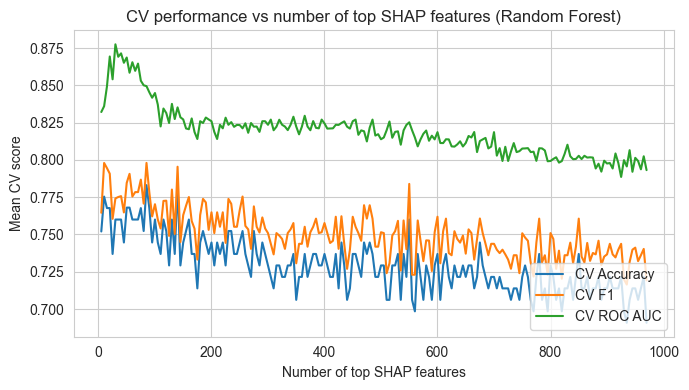


===== Evaluating MI feature ranking =====

CV results (mean over folds):
     Top_N  CV_Accuracy     CV_F1  CV_ROC_AUC
0        5     0.649846  0.681054    0.726557
1       10     0.705538  0.719805    0.766850
2       15     0.697846  0.713015    0.746612
3       20     0.682462  0.693552    0.769185
4       25     0.682462  0.692656    0.773535
..     ...          ...       ...         ...
189    950     0.690769  0.713492    0.791255
190    955     0.698462  0.726997    0.793315
191    960     0.698462  0.720356    0.791850
192    965     0.690769  0.715517    0.793315
193    970     0.698462  0.726305    0.788462

[194 rows x 4 columns]

Best N by CV F1 (MI): 265
Top_N          265.000000
CV_Accuracy      0.752308
CV_F1            0.777980
CV_ROC_AUC       0.807875
Name: 52, dtype: float64


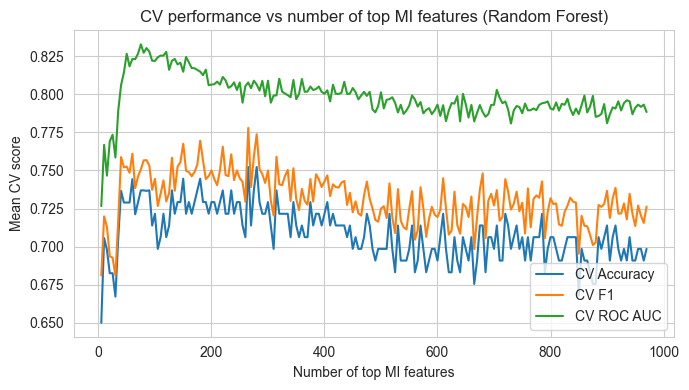

NameError: name 'kbest_features' is not defined

In [40]:
best_shap, shap_cv_table = evaluate_rf_feature_method(
    "SHAP", shap_features, X_train, y_train)

best_mi, mi_cv_table = evaluate_rf_feature_method(
    "MI", mi_features, X_train, y_train)

best_perm, perm_cv_table = evaluate_rf_feature_method(
    "PI", perm_features, X_train, y_train)

best_lasso, lasso_cv_table = evaluate_rf_feature_method(
    "Lasso", lasso_features, X_train, y_train)

## Train Model Features

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def train_final_rf_model(method_name, feature_ranking, best_n,
                         X_train, X_test, y_train, y_test):
    """
    Строит финальную Random Forest модель на лучших фичах,
    найденных методом SHAP / RF / KBest / Lasso.

    method_name: строка ('SHAP', 'RF', 'KBest', 'Lasso')
    feature_ranking: pd.Series — ранжированные фичи
    best_n: количество лучших фич из evaluate_rf_feature_method()
    """

    print(f"\n===== FINAL Random Forest model using {best_n} {method_name} features =====")

    # выбираем топ-N фич
    top_feats = feature_ranking.head(best_n).index.tolist()

    # создаём финальную Random Forest модель
    final_model = RandomForestClassifier(
        n_estimators=best_n,      # число деревьев = число фич
        random_state=42,
        class_weight="balanced"
    )

    # обучение модели
    final_model.fit(X_train[top_feats], y_train)

    # предсказание
    y_pred = final_model.predict(X_test[top_feats])
    y_prob = final_model.predict_proba(X_test[top_feats])[:, 1]

    # считаем метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    auc  = roc_auc_score(y_test, y_prob)

    # выводим отчёт
    print(f"\nFinal model performance ({method_name}) on TEST:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 score:  {f1:.4f}")
    print(f"ROC AUC:   {auc:.4f}")

    log_result(
    method_name,
    model_type="Baseline_RF",
    n_features=best_n,
    metrics={
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    },
    params={
        "n_estimators": X_train.shape[1],
        "class_weight": "balanced"
    },
    stage="final"
)


    # 7возвращаем модель и метрики
    return final_model, {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc,
        "Top_Features": top_feats
    }


In [43]:
final_shap_model, shap_metrics = train_final_rf_model(
    "SHAP", shap_features, best_shap, X_train, X_test, y_train, y_test
)

final_mi_model, mi_metrics = train_final_rf_model(
    "MI", mi_features, best_mi, X_train, X_test, y_train, y_test
)

final_perm_model, perm_metrics = train_final_rf_model(
    "PI", perm_features, best_perm, X_train, X_test, y_train, y_test
)

final_lasso_model, lasso_metrics = train_final_rf_model(
    "Lasso", lasso_features, best_lasso, X_train, X_test, y_train, y_test
)



===== FINAL Random Forest model using 85 SHAP features =====

Final model performance (SHAP) on TEST:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7574

===== FINAL Random Forest model using 265 MI features =====

Final model performance (MI) on TEST:
Accuracy:  0.6970
Precision: 0.7222
Recall:    0.7222
F1 score:  0.7222
ROC AUC:   0.7907

===== FINAL Random Forest model using 905 PI features =====

Final model performance (PI) on TEST:
Accuracy:  0.6970
Precision: 0.7222
Recall:    0.7222
F1 score:  0.7222
ROC AUC:   0.7926

===== FINAL Random Forest model using 5 PI features =====

Final model performance (PI) on TEST:
Accuracy:  0.6061
Precision: 0.6667
Recall:    0.5556
F1 score:  0.6061
ROC AUC:   0.6315

===== FINAL Random Forest model using 25 Lasso features =====

Final model performance (Lasso) on TEST:
Accuracy:  0.6970
Precision: 0.7500
Recall:    0.6667
F1 score:  0.7059
ROC AUC:   0.7315


## Model Feautures Tunning (Optuna)

In [64]:
def tune_rf_optuna(method_name, feature_ranking, best_n,
                   X_train, X_test, y_train, y_test, n_trials=100):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)

    n_min = max(10, int(best_n * 0.5))
    n_max = max(n_min + 1, int(best_n * 1.25))

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", n_min, n_max),
            "max_depth": trial.suggest_int("max_depth", 4, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.3, 0.5, None]),
            "bootstrap": True,
            "class_weight": "balanced",
            "random_state": 42,
            "n_jobs": -1,
        }

        model = RandomForestClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(
            model, X_train_fs, y_train,
            cv=cv, scoring="f1", n_jobs=-1
        ).mean()

        return scores

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
        "Best_N": best_n,
        "Feature_Ranking": feature_ranking,
    }


## Model Feautures Tunning (Optuna + gboost)

In [65]:
from optuna import trial


def tune_advanced_tree_model(method_name, feature_ranking, best_n,
                             X_train, X_test, y_train, y_test, n_trials=50):

    top_feats = feature_ranking.head(best_n).index.tolist()
    X_train_fs = X_train[top_feats]
    X_test_fs  = X_test[top_feats]

    optuna.logging.set_verbosity(optuna.logging.ERROR)


    n_min = max(10, int(best_n * 0.5))
    n_max = max(n_min + 1, int(best_n * 1.25))

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", n_min, n_max),
            "max_depth": trial.suggest_int("max_depth", 4, 12),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", 0.3, 0.5, None]),
            "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.15),
            }

        model = GradientBoostingClassifier(**params)

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(
            model,
            X_train_fs,
            y_train,
            cv=cv,
            scoring="f1",
            n_jobs=-1
        ).mean()

        return scores

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    best_params = study.best_params

    final_model = GradientBoostingClassifier(random_state=42, **best_params)
    final_model.fit(X_train_fs, y_train)

    y_pred = final_model.predict(X_test_fs)
    y_prob = final_model.predict_proba(X_test_fs)[:, 1]

    return {
        "Method": method_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Params": study.best_params,
        "Best_N": best_n,
        "Feature_Ranking": feature_ranking,
    }

## Result

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

methods = {
    "SHAP": (shap_features, best_shap),
    "MI": (mi_features, best_mi),
    "PI": (perm_features, best_perm),
    "Lasso": (lasso_features, best_lasso),
}

rf_rows = []
for name, (ranking, best_n) in methods.items():
    rf_rows.append(
        tune_rf_optuna(name, ranking, best_n,
                       X_train, X_test, y_train, y_test)
    )

rf_results_df = pd.DataFrame(rf_rows)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
rf_results_df

,Method,Model,Feature_Ranking,Best_N,AUC,Accuracy,Precision,Recall,F1,Params
0,SHAP,RandomForest,FP_3775 0.011911 FP_2889 0.007847 FP_5...,85,0.759259,0.666667,0.733333,0.611111,0.666667,"{'n_estimators': 92, 'max_depth': 7, 'min_samp..."
1,MI,RandomForest,BCUT2D_MWHI 0.679965 qed ...,265,0.803704,0.787879,0.823529,0.777778,0.800000,"{'n_estimators': 140, 'max_depth': 9, 'min_sam..."
2,PI,RandomForest,MolWt 0.001550 FP_2889 ...,905,0.788889,0.696970,0.722222,0.722222,0.722222,"{'n_estimators': 908, 'max_depth': 8, 'min_sam..."
3,Lasso,RandomForest,FP_5023 1.267817 FP_3875 0...,25,0.714815,0.666667,0.705882,0.666667,0.685714,"{'n_estimators': 21, 'max_depth': 12, 'min_sam..."


In [69]:
best_rf_row = rf_results_df.loc[rf_results_df["AUC"].idxmax()]
rf_best_params = best_rf_row["Params"]
rf_best_n = best_rf_row["Best_N"]
rf_best_method = best_rf_row["Method"]

print("Best RF:", rf_best_method, rf_best_n, rf_best_params)

Best RF: MI 265 {'n_estimators': 140, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.5}
Best GB: SHAP 85 {'n_estimators': 90, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'learning_rate': 0.048880736446016676}


## Dinamic


=== Testing top 5 SHAP features ===
CV Accuracy (mean over folds): 0.768

=== Testing top 6 SHAP features ===
CV Accuracy (mean over folds): 0.760

=== Testing top 7 SHAP features ===
CV Accuracy (mean over folds): 0.752

=== Testing top 8 SHAP features ===
CV Accuracy (mean over folds): 0.737

=== Testing top 9 SHAP features ===
CV Accuracy (mean over folds): 0.745

=== Testing top 10 SHAP features ===
CV Accuracy (mean over folds): 0.737

=== Testing top 11 SHAP features ===
CV Accuracy (mean over folds): 0.729

=== Testing top 12 SHAP features ===
CV Accuracy (mean over folds): 0.737

=== Testing top 13 SHAP features ===
CV Accuracy (mean over folds): 0.745

=== Testing top 14 SHAP features ===
CV Accuracy (mean over folds): 0.752

=== Testing top 15 SHAP features ===
CV Accuracy (mean over folds): 0.745

=== Testing top 16 SHAP features ===
CV Accuracy (mean over folds): 0.768

=== Testing top 17 SHAP features ===
CV Accuracy (mean over folds): 0.752

=== Testing top 18 SHAP featu

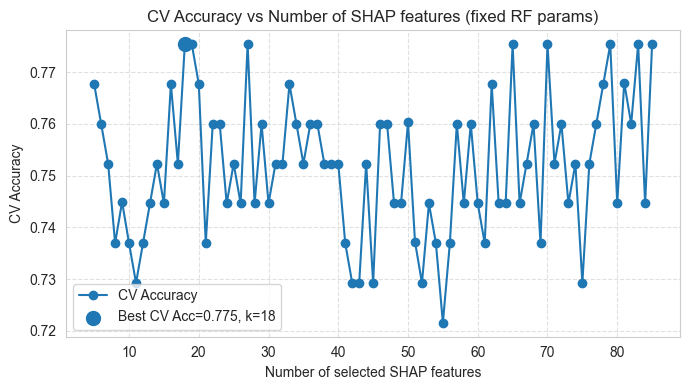


=== Final evaluation on TEST with best k from CV ===
RF best_params_shap: {'n_estimators': 92, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.5}
TEST Accuracy: 0.667 | TEST ROC-AUC: 0.722


In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

# Ранжирование признаков (SHAP)
ranking = shap_features   # Series: feature -> importance
shap_row = rf_results_df[rf_results_df["Method"] == "SHAP"].iloc[0]
best_params_shap = shap_row["Params"]

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Sweep по числу признаков (ТОЛЬКО CV, без теста!)
for k in range(5, best_shap + 1, 1):
    print(f"\n=== Testing top {k} SHAP features ===")

    # Выбор top-k фичей
    top_feats = ranking.head(k).index.tolist()
    X_train_sel = X_train[top_feats]
    X_test_sel = X_test[top_feats]

    # Модель
    rf_clf = RandomForestClassifier(
        **best_params_shap,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    # CV-оценка (accuracy, можно заменить на 'f1')
    scores = cross_val_score(
        rf_clf,
        X_train_sel,
        y_train,
        cv=cv,
        scoring="accuracy",
        n_jobs=-1
    )
    acc = scores.mean()
    results.append((k, acc))
    print(f"CV Accuracy (mean over folds): {acc:.3f}")

# Анализ результатов по CV
results = np.array(results)
feature_counts = results[:, 0]
accuracies = results[:, 1]

best_index = np.argmax(accuracies)
best_k = int(feature_counts[best_index])
best_cv_acc = accuracies[best_index]

print(f"\nBest k by CV Accuracy: k = {best_k}, CV_Acc = {best_cv_acc:.3f}")

# График по CV
plt.figure(figsize=(7, 4))
plt.plot(feature_counts, accuracies, 'o-', label='CV Accuracy')
plt.scatter(best_k, best_cv_acc, s=100, zorder=5,
            label=f'Best CV Acc={best_cv_acc:.3f}, k={best_k}')
plt.title('CV Accuracy vs Number of SHAP features (fixed RF params)')
plt.xlabel('Number of selected SHAP features')
plt.ylabel('CV Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# ===== Финальная оценка на TEST (один раз!) =====
print("\n=== Final evaluation on TEST with best k from CV ===")

top_feats_final = ranking.head(best_k).index.tolist()
X_train_best = X_train[top_feats_final]
X_test_best = X_test[top_feats_final]

final_model = RandomForestClassifier(
    **best_params_shap,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_best, y_train)

y_pred = final_model.predict(X_test_best)
y_prob = final_model.predict_proba(X_test_best)[:, 1]

test_acc = accuracy_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_prob)

print(f"RF best_params_shap: {best_params_shap}")
print(f"TEST Accuracy: {test_acc:.3f} | TEST ROC-AUC: {test_auc:.3f}")

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score


def sweep_k_features_with_fixed_rf(
    method_name,
    feature_ranking,      # pd.Series: feature -> importance (SHAP/MI/...)
    best_n_method,        # напр. best_shap
    best_params,          # dict из tune_rf_optuna: study.best_params
    X_train,
    X_test,
    y_train,
    y_test,
    k_min=5,
    scoring="accuracy",
    plot=True,
):

    print(f"\n=== sweep_k_features_with_fixed_rf for {method_name} ===")

    ranking = feature_ranking
    max_k = int(best_n_method)

    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Sweep по числу признаков (ТОЛЬКО CV, без теста!)
    for k in range(k_min, max_k + 1):
        print(f"\n--- Testing top {k} {method_name} features (CV only) ---")

        # Выбор top-k фичей
        top_feats = ranking.head(k).index.tolist()
        X_train_sel = X_train[top_feats]

        # Модель с уже найденными лучшими параметрами
        rf_clf = RandomForestClassifier(
            **best_params,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        )

        # CV-оценка
        scores = cross_val_score(
            rf_clf,
            X_train_sel,
            y_train,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = scores.mean()
        results.append((k, mean_score))

        print(f"CV {scoring} (mean over folds): {mean_score:.3f}")

    # Анализ результатов по CV
    results = np.array(results)
    feature_counts = results[:, 0]
    cv_scores = results[:, 1]

    best_index = np.argmax(cv_scores)
    best_k = int(feature_counts[best_index])
    best_cv_score = cv_scores[best_index]

    print(f"\nBest k by CV {scoring}: k = {best_k}, CV_{scoring} = {best_cv_score:.3f}")

    # График по CV
    if plot:
        plt.figure(figsize=(7, 4))
        plt.plot(feature_counts, cv_scores, 'o-', label=f'CV {scoring}')
        plt.scatter(best_k, best_cv_score, s=100, zorder=5,
                    label=f'Best CV {scoring}={best_cv_score:.3f}, k={best_k}')
        plt.title(f'CV {scoring} vs Number of {method_name} features (fixed RF params)')
        plt.xlabel(f'Number of selected {method_name} features')
        plt.ylabel(f'CV {scoring}')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()

    # ===== Финальная оценка на TEST (один раз!) =====
    print("\n=== Final evaluation on TEST with best k from CV ===")

    top_feats_final = ranking.head(best_k).index.tolist()
    X_train_best = X_train[top_feats_final]
    X_test_best = X_test[top_feats_final]

    final_model = RandomForestClassifier(
        **best_params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )
    final_model.fit(X_train_best, y_train)

    y_pred = final_model.predict(X_test_best)
    y_prob = final_model.predict_proba(X_test_best)[:, 1]

    test_acc = accuracy_score(y_test, y_pred)
    test_auc = roc_auc_score(y_test, y_prob)

    print(f"RF best_params ({method_name}): {best_params}")
    print(f"TEST Accuracy: {test_acc:.3f} | TEST ROC-AUC: {test_auc:.3f}")

    return {
        "method": method_name,
        "best_k": best_k,
        "best_cv_score": best_cv_score,
        "cv_scoring": scoring,
        "test_accuracy": test_acc,
        "test_auc": test_auc,
        "best_params": best_params,
        "cv_curve": (feature_counts, cv_scores),
        "top_features": top_feats_final,
        "final_model": final_model,
    }


=== sweep_k_features_with_fixed_rf for SHAP ===

--- Testing top 5 SHAP features (CV only) ---
CV f1 (mean over folds): 0.785

--- Testing top 6 SHAP features (CV only) ---
CV f1 (mean over folds): 0.778

--- Testing top 7 SHAP features (CV only) ---
CV f1 (mean over folds): 0.770

--- Testing top 8 SHAP features (CV only) ---
CV f1 (mean over folds): 0.752

--- Testing top 9 SHAP features (CV only) ---
CV f1 (mean over folds): 0.761

--- Testing top 10 SHAP features (CV only) ---
CV f1 (mean over folds): 0.755

--- Testing top 11 SHAP features (CV only) ---
CV f1 (mean over folds): 0.750

--- Testing top 12 SHAP features (CV only) ---
CV f1 (mean over folds): 0.753

--- Testing top 13 SHAP features (CV only) ---
CV f1 (mean over folds): 0.766

--- Testing top 14 SHAP features (CV only) ---
CV f1 (mean over folds): 0.769

--- Testing top 15 SHAP features (CV only) ---
CV f1 (mean over folds): 0.765

--- Testing top 16 SHAP features (CV only) ---
CV f1 (mean over folds): 0.784

--- Tes

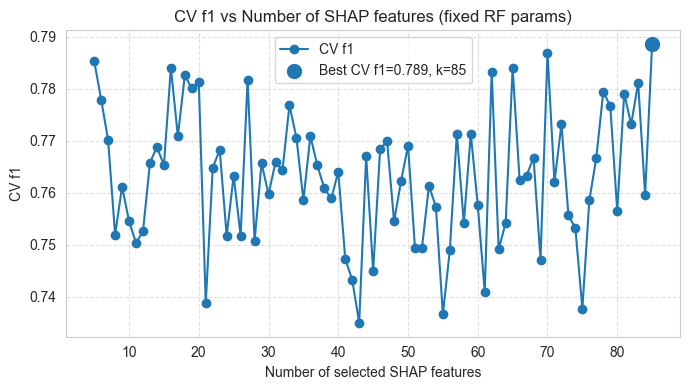


=== Final evaluation on TEST with best k from CV ===
RF best_params (SHAP): {'n_estimators': 92, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 0.5}
TEST Accuracy: 0.667 | TEST ROC-AUC: 0.759


In [77]:
# достаём best_params для SHAP из rf_results_df
shap_row = rf_results_df[rf_results_df["Method"] == "SHAP"].iloc[0]
best_params_shap = shap_row["Params"]
best_shap = shap_row["Best_N"]      # или уже имеешь отдельно

res_shap = sweep_k_features_with_fixed_rf(
    method_name="SHAP",
    feature_ranking=shap_features,
    best_n_method=best_shap,
    best_params=best_params_shap,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)


=== sweep_k_features_with_fixed_rf for MI ===

--- Testing top 5 MI features (CV only) ---
CV f1 (mean over folds): 0.635

--- Testing top 6 MI features (CV only) ---
CV f1 (mean over folds): 0.728

--- Testing top 7 MI features (CV only) ---
CV f1 (mean over folds): 0.704

--- Testing top 8 MI features (CV only) ---
CV f1 (mean over folds): 0.721

--- Testing top 9 MI features (CV only) ---
CV f1 (mean over folds): 0.689

--- Testing top 10 MI features (CV only) ---
CV f1 (mean over folds): 0.686

--- Testing top 11 MI features (CV only) ---
CV f1 (mean over folds): 0.676

--- Testing top 12 MI features (CV only) ---
CV f1 (mean over folds): 0.670

--- Testing top 13 MI features (CV only) ---
CV f1 (mean over folds): 0.672

--- Testing top 14 MI features (CV only) ---
CV f1 (mean over folds): 0.670

--- Testing top 15 MI features (CV only) ---
CV f1 (mean over folds): 0.685

--- Testing top 16 MI features (CV only) ---
CV f1 (mean over folds): 0.631

--- Testing top 17 MI features (C

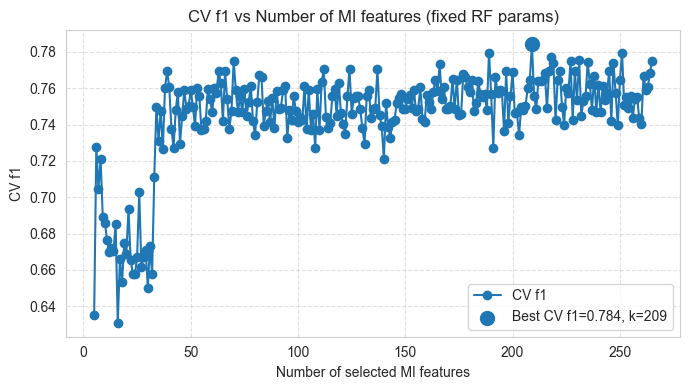


=== Final evaluation on TEST with best k from CV ===
RF best_params (MI): {'n_estimators': 140, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 0.5}
TEST Accuracy: 0.758 | TEST ROC-AUC: 0.800


In [78]:
# достаём best_params для SHAP из rf_results_df
mi_row = rf_results_df[rf_results_df["Method"] == "MI"].iloc[0]
best_params_mi = mi_row["Params"]
best_mi = mi_row["Best_N"]      # или уже имеешь отдельно

res_mi = sweep_k_features_with_fixed_rf(
    method_name="MI",
    feature_ranking=mi_features,
    best_n_method=best_mi,
    best_params=best_params_mi,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)


=== sweep_k_features_with_fixed_rf for PI ===

--- Testing top 5 PI features (CV only) ---
CV f1 (mean over folds): 0.735

--- Testing top 6 PI features (CV only) ---
CV f1 (mean over folds): 0.738

--- Testing top 7 PI features (CV only) ---
CV f1 (mean over folds): 0.725

--- Testing top 8 PI features (CV only) ---
CV f1 (mean over folds): 0.729

--- Testing top 9 PI features (CV only) ---
CV f1 (mean over folds): 0.738

--- Testing top 10 PI features (CV only) ---
CV f1 (mean over folds): 0.731

--- Testing top 11 PI features (CV only) ---
CV f1 (mean over folds): 0.735

--- Testing top 12 PI features (CV only) ---
CV f1 (mean over folds): 0.722

--- Testing top 13 PI features (CV only) ---
CV f1 (mean over folds): 0.722

--- Testing top 14 PI features (CV only) ---
CV f1 (mean over folds): 0.722

--- Testing top 15 PI features (CV only) ---
CV f1 (mean over folds): 0.722

--- Testing top 16 PI features (CV only) ---
CV f1 (mean over folds): 0.710

--- Testing top 17 PI features (C

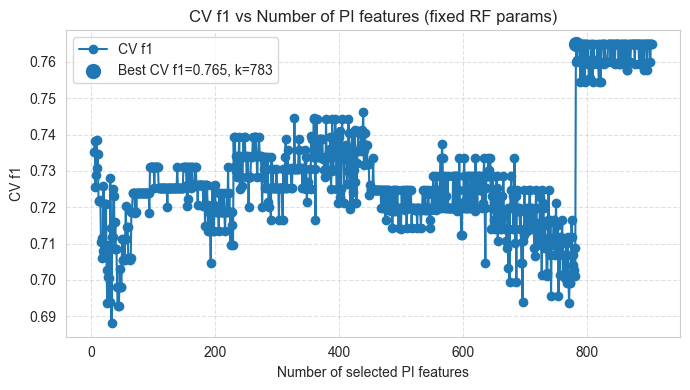


=== Final evaluation on TEST with best k from CV ===
RF best_params (PI): {'n_estimators': 908, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}
TEST Accuracy: 0.697 | TEST ROC-AUC: 0.796


In [79]:
# достаём best_params для SHAP из rf_results_df
perm_row = rf_results_df[rf_results_df["Method"] == "PI"].iloc[0]
best_params_perm = perm_row["Params"]
best_perm = perm_row["Best_N"]      # или уже имеешь отдельно

res_perm = sweep_k_features_with_fixed_rf(
    method_name="PI",
    feature_ranking=perm_features,
    best_n_method=best_perm,
    best_params=best_params_perm,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)


=== sweep_k_features_with_fixed_rf for Lasso ===

--- Testing top 5 Lasso features (CV only) ---
CV f1 (mean over folds): 0.740

--- Testing top 6 Lasso features (CV only) ---
CV f1 (mean over folds): 0.791

--- Testing top 7 Lasso features (CV only) ---
CV f1 (mean over folds): 0.822

--- Testing top 8 Lasso features (CV only) ---
CV f1 (mean over folds): 0.830

--- Testing top 9 Lasso features (CV only) ---
CV f1 (mean over folds): 0.848

--- Testing top 10 Lasso features (CV only) ---
CV f1 (mean over folds): 0.814

--- Testing top 11 Lasso features (CV only) ---
CV f1 (mean over folds): 0.834

--- Testing top 12 Lasso features (CV only) ---
CV f1 (mean over folds): 0.810

--- Testing top 13 Lasso features (CV only) ---
CV f1 (mean over folds): 0.811

--- Testing top 14 Lasso features (CV only) ---
CV f1 (mean over folds): 0.780

--- Testing top 15 Lasso features (CV only) ---
CV f1 (mean over folds): 0.830

--- Testing top 16 Lasso features (CV only) ---
CV f1 (mean over folds): 0

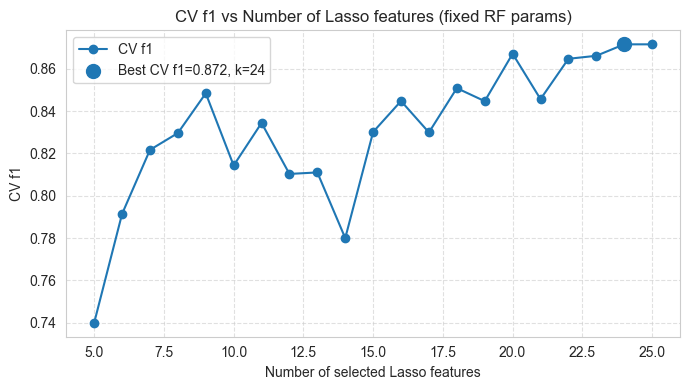


=== Final evaluation on TEST with best k from CV ===
RF best_params (Lasso): {'n_estimators': 21, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}
TEST Accuracy: 0.667 | TEST ROC-AUC: 0.737


In [80]:
# достаём best_params для SHAP из rf_results_df
lasso_row = rf_results_df[rf_results_df["Method"] == "Lasso"].iloc[0]
best_params_lasso = lasso_row["Params"]
best_lasso = lasso_row["Best_N"]

res_lasso = sweep_k_features_with_fixed_rf(
    method_name="Lasso",
    feature_ranking=lasso_features,
    best_n_method=best_lasso,
    best_params=best_params_lasso,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    k_min=5,
    scoring="f1",
    plot=True,
)

In [ ]:
import pandas as pd

# 1. rf_results_df уже есть (результаты Optuna)
# Колонки: ["Method", "AUC", "Accuracy", "Precision", "Recall", "F1", "Params", "Best_N", "Feature_Ranking"]

# 2. Предположим, ты вызывала sweep-функцию так:
# res_shap  = sweep_k_features_with_fixed_rf(...)
# res_mi    = sweep_k_features_with_fixed_rf(...)
# res_pi    = sweep_k_features_with_fixed_rf(...)
# res_lasso = sweep_k_features_with_fixed_rf(...)

sweep_rows = []

for res in [res_shap, res_mi, res_perm, res_lasso]:
    sweep_rows.append({
        "Method":      res["method"],
        "CV_metric":   res["cv_scoring"],          # "f1" или "accuracy"
        "CV_best_k":   res["best_k"],
        "CV_best_val": res["best_cv_score"],
        "TEST_AUC":    res["test_auc"],
        "TEST_Acc":    res["test_accuracy"],
        "Params":      res["best_params"],
    })

sweep_df = pd.DataFrame(sweep_rows)

# 3. Сохранение в CSV: отдельно и вместе

rf_results_df.to_csv("rf_results_optuna.csv", index=False, encoding="utf-8")
sweep_df.to_csv("rf_results_sweep_k.csv", index=False, encoding="utf-8")

# 4. Совместная таблица для удобного сравнения

# Переименуем колонки в rf_results_df, чтобы было понятно, что это Optuna
rf_optuna_view = rf_results_df[["Method", "AUC", "Accuracy", "Precision", "Recall", "F1", "Best_N", "Params"]].copy()
rf_optuna_view = rf_optuna_view.rename(columns={
    "AUC": "Optuna_AUC",
    "Accuracy": "Optuna_Acc",
    "Precision": "Optuna_Precision",
    "Recall": "Optuna_Recall",
    "F1": "Optuna_F1",
    "Best_N": "Optuna_k",
})

# Объединим по колонке Method
combined_df = rf_optuna_view.merge(sweep_df, on="Method", how="left")

combined_df.to_csv("rf_results_optuna_vs_sweep.csv", index=False, encoding="utf-8")

print("Saved:")
print(" - rf_results_optuna.csv")
print(" - rf_results_sweep_k.csv")
print(" - rf_results_optuna_vs_sweep.csv")
print("\nCombined view:")
print(combined_df.head().to_string(index=False))


In [81]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score


def find_best_threshold_cv(model, X_train, y_train,
                           metric="f1", n_splits=5):
    """
    Подбор оптимального порога по k-fold CV на train.
    metric: "f1" или "accuracy".
    Возвращает лучший порог и среднее значение метрики по CV.
    """

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    thresholds = np.linspace(0.1, 0.9, 81)   # шаг 0.01

    best_thr = 0.5
    best_score = -np.inf

    for thr in thresholds:
        fold_scores = []

        for train_idx, val_idx in cv.split(X_train, y_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # обучаем копию модели на фолде
            mdl = clone(model)
            mdl.fit(X_tr, y_tr)

            proba = mdl.predict_proba(X_val)[:, 1]
            preds = (proba >= thr).astype(int)

            if metric == "accuracy":
                s = accuracy_score(y_val, preds)
            else:
                s = f1_score(y_val, preds)

            fold_scores.append(s)

        mean_score = np.mean(fold_scores)
        if mean_score > best_score:
            best_score = mean_score
            best_thr = thr

    return best_thr, best_score


In [82]:
from sklearn.base import clone

# Допустим, у тебя есть:
# best_params_mi, mi_best_k, mi_features (pd.Index топ-фич), X_train, X_test, y_train, y_test

X_train_mi = X_train[mi_features]
X_test_mi = X_test[mi_features]

base_rf_mi = RandomForestClassifier(
    **best_params_mi,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
base_rf_mi.fit(X_train_mi, y_train)

# Подбор порога по CV
best_thr_mi, best_cv_f1_mi = find_best_threshold_cv(
    base_rf_mi, X_train_mi, y_train,
    metric="f1", n_splits=5
)
print(f"Best threshold (MI RF) by CV F1: thr={best_thr_mi:.2f}, CV_F1={best_cv_f1_mi:.3f}")

# Оценка на тесте с этим порогом
proba_test = base_rf_mi.predict_proba(X_test_mi)[:, 1]
y_pred_thr = (proba_test >= best_thr_mi).astype(int)

acc = accuracy_score(y_test, y_pred_thr)
f1 = f1_score(y_test, y_pred_thr)
auc = roc_auc_score(y_test, proba_test)

print(f"TEST with tuned threshold (MI RF): Acc={acc:.3f}, F1={f1:.3f}, AUC={auc:.3f}")


KeyError: "None of [Index([    0.6799649864418517,     0.6799649864418517,     0.6799649864418515,\n            0.662528237771501,     0.6544158634495699,     0.6469641446655823,\n           0.6320374345862244,      0.630513671518613,     0.6063006035555544,\n           0.5971386258425986,\n       ...\n       0.00011678554903099547, 0.00011678554903099547,  8.819842023660707e-05,\n        8.651617749971807e-05,   6.70886269940052e-05, 5.4810596432142145e-05,\n        2.245680911583392e-05, 1.7375935689234456e-05,  2.587820769173188e-06,\n                          0.0],\n      dtype='float64', length=974)] are in the [columns]"

# XSMILES


In [36]:
import io
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from explain import _explain_by_groups, explain_atom_importance

from explain import _explain_by_groups, explain_atom_importance
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import io
import numpy as np
import matplotlib.pyplot as plt


# =========================
# 1. ЧИСТАЯ descriptor_fn
# =========================
def make_descriptor_fn(train_medians, iqr_limits, numeric_cols, trained_columns):

    def descriptor_fn(mol):
        if mol is None:
            raise ValueError("descriptor_fn: got None mol")

        # RAW descriptors
        desc = calculate_descriptors(mol)
        fp   = calculate_maccs_fingerprint(mol)
        row = {**desc, **fp}
        df = pd.DataFrame([row])

        # restore only known columns
        df = df.reindex(columns=train_medians.index, fill_value=np.nan)

        # fill NaNs
        df = df.fillna(train_medians)

        # 3. IQR only on numeric (SAFE)
        for col in numeric_cols:
            if col in df.columns and col in iqr_limits:
                low, high = iqr_limits[col]
                df[col] = np.clip(df[col], low, high)


        # keep only trained columns
        df_final = df.reindex(columns=trained_columns, fill_value=0)

        assert list(df_final.columns) == list(trained_columns), \
            "Feature misalignment!"

        return df_final.to_numpy()[0]

    return descriptor_fn



def explain_smarts_groups(model, mol, descriptor_fn, groups, normalize=True):
    atts, base = _explain_by_groups(model, mol, descriptor_fn, groups)
    if normalize and atts.std() > 0:
        atts = (atts - atts.mean()) / atts.std()
    return atts, base, groups

def tokenize_smiles(smiles: str):
    tokens = []
    i = 0
    while i < len(smiles):
        if i + 1 < len(smiles) and smiles[i:i+2] in ["Cl", "Br"]:
            tokens.append(smiles[i:i+2])
            i += 2
            continue
        if smiles[i] == "[":
            j = i + 1
            while j < len(smiles) and smiles[j] != "]":
                j += 1
            tokens.append(smiles[i:j+1])
            i = j + 1
            continue
        tokens.append(smiles[i])
        i += 1

    return tokens

def tokens_to_groups(tokens, mol):
    groups = []
    atom_counter = 0
    n_atoms = mol.GetNumAtoms()

    for tok in tokens:
        if tok.startswith("[") or tok in ["Cl", "Br"] or tok.isalpha():
            if atom_counter < n_atoms:
                groups.append([atom_counter])
                atom_counter += 1
            else:
                groups.append([])
        else:
            groups.append([])
    return groups



def compute_token_importance(model, mol, descriptor_fn, tokens):
    groups = tokens_to_groups(tokens, mol)
    scores, base, _ = explain_smarts_groups(model, mol, descriptor_fn, groups)
    return scores, base

def xsmiles_visualize(mol, atom_scores, smiles_scores, tokens):
    import numpy as np
    import matplotlib.pyplot as plt
    import io
    from rdkit.Chem import rdDepictor
    from rdkit.Chem.Draw import rdMolDraw2D

    assert len(tokens) == len(smiles_scores), \
        f"Tokens={len(tokens)} but scores={len(smiles_scores)}"

    # 1. Atom-level highlighting (XSMILES style)
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 400)
    rdDepictor.Compute2DCoords(mol)
    max_abs = max(abs(atom_scores))
    atom_colors = {}
    for i, score in enumerate(atom_scores):

        alpha = min(1.0, abs(score) / max_abs)

        if score >= 0:
            atom_colors[i] = (0.6, 0.0, 0.6, alpha)      # purple
        else:
            atom_colors[i] = (0.0, 0.5, 1.0, alpha)      # cyan
    drawer.DrawMolecule(
        mol,
        highlightAtoms=list(atom_colors.keys()),
        highlightAtomColors=atom_colors
    )
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()

    # 2. SMILES token barplot (purple = positive, cyan = negative)
    plt.figure(figsize=(16, 8))
    # Molecule
    plt.subplot(2, 1, 1)
    plt.imshow(plt.imread(io.BytesIO(png)))
    plt.axis("off")
    # Token importance bars
    plt.subplot(2, 1, 2)
    x = np.arange(len(tokens))
    # цвета для каждого токена
    bar_colors = [
        (0.6, 0.0, 0.6) if s >= 0 else (0.0, 0.5, 1.0)
        for s in smiles_scores
    ]
    plt.bar(x, smiles_scores, color=bar_colors)
    # горизонтальные подписи
    plt.xticks(x, tokens, rotation=0, fontsize=9)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.tight_layout()
    plt.show()



def run_xsmiles_pipeline(
    model,
    smiles,
    train_medians,
    iqr_limits,
    numeric_cols,
    trained_columns
):

    # Create descriptor_fn with closure
    descriptor = make_descriptor_fn(train_medians, iqr_limits, numeric_cols, trained_columns)

    # RDKit mol
    mol, status = molecule_from_smiles(smiles)
    if mol is None:
        raise ValueError(f"SMILES parsing failed: {status}")

    # Atom importance
    atom_scores, base_atom = explain_atom_importance(
        model=model,
        mol=mol,
        descriptor_fn=descriptor,
        normalize=True
    )

    # Token importance
    smiles_canonical = Chem.MolToSmiles(mol, canonical=True)
    tokens = tokenize_smiles(smiles_canonical)
    token_scores, base_token = compute_token_importance(
        model=model,
        mol=mol,
        descriptor_fn=descriptor,
        tokens=tokens
    )

    # Visualization
    xsmiles_visualize(mol, atom_scores, token_scores, tokens)

    return {
        "smiles": smiles,
        "tokens": tokens,
        "atom_scores": atom_scores,
        "token_scores": token_scores,
        "base_atom_pred": float(base_atom),
        "base_token_pred": float(base_token)
    }



C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\sirad\PycharmProjects\TP\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


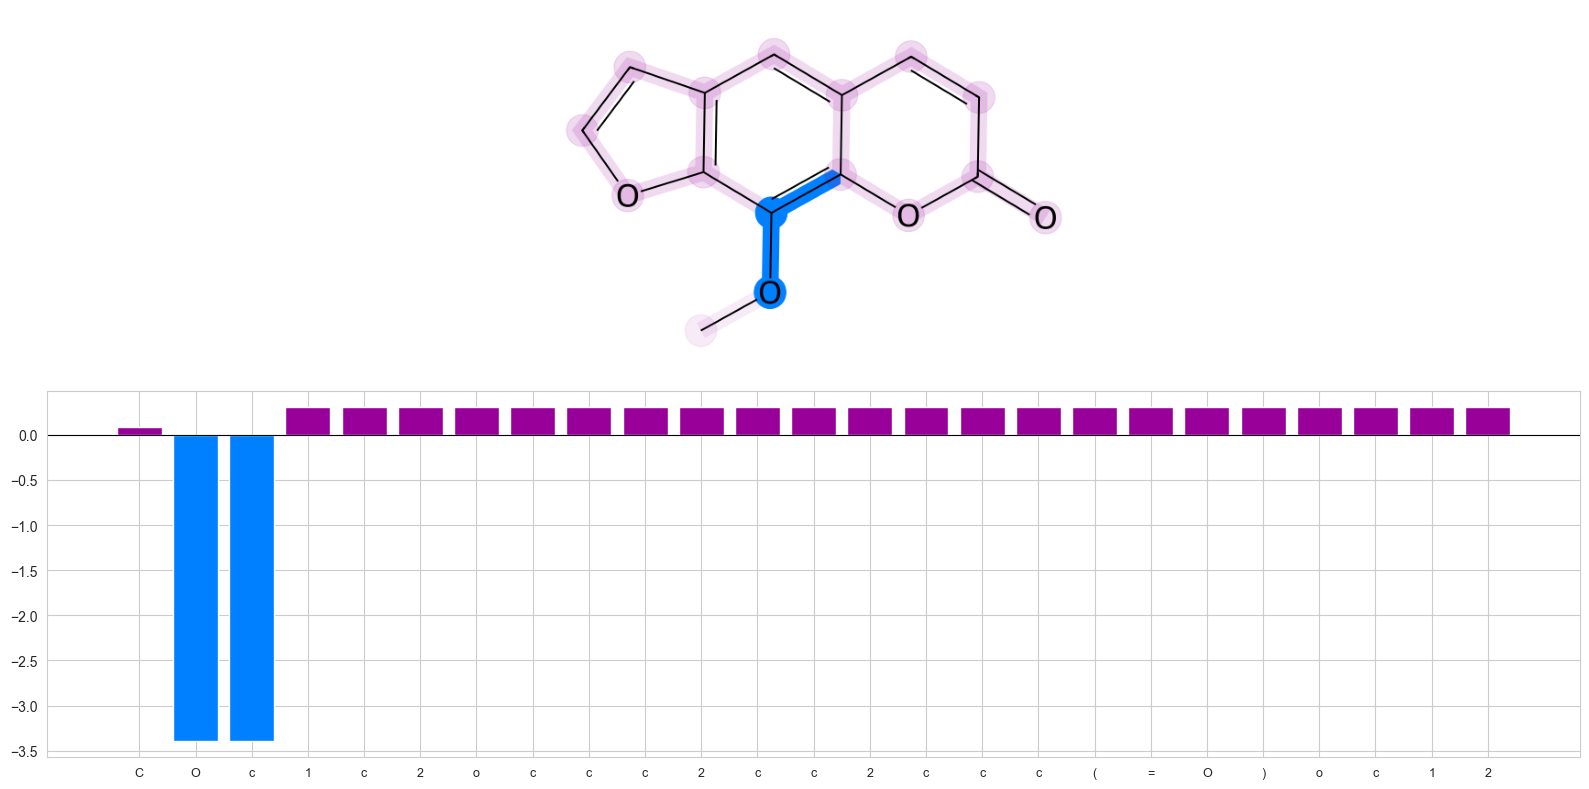

{'smiles': 'COC1=C2C(=CC3=C1OC=C3)C=CC(=O)O2',
 'tokens': ['C',
  'O',
  'c',
  '1',
  'c',
  '2',
  'o',
  'c',
  'c',
  'c',
  '2',
  'c',
  'c',
  '2',
  'c',
  'c',
  'c',
  '(',
  '=',
  'O',
  ')',
  'o',
  'c',
  '1',
  '2'],
 'atom_scores': array([ 0.20950879, -2.64323418, -2.64323418,  0.39053535,  0.39053535,
         0.39053535,  0.39053535,  0.39053535,  0.39053535,  0.39053535,
         0.39053535,  0.39053535,  0.39053535,  0.39053535,  0.39053535,
         0.39053535]),
 'token_scores': array([ 0.08387326, -3.38801459, -3.38801459,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891,
         0.30418891,  0.30418891,  0.30418891,  0.30418891,  0.30418891]),
 'base_atom_pred': 0.45688378632710863,
 'base_token_pred': 0.45688378632710863}

In [37]:
numeric_cols = [c for c in X_train.columns if X_train[c].nunique() > 10]
trained_columns = gb_lasso_metrics["Top_Features"]

result = run_xsmiles_pipeline(
    model=gb_lasso_model,
    smiles=dataset_ok.loc[5, "SMILES code"],
    train_medians=train_medians,
    iqr_limits=iqr_limits,
    numeric_cols=numeric_cols,
    trained_columns=trained_columns
)

result